In [251]:
import os
import numpy as np
import pandas as pd
import fiona
import rasterio as rio
from rasterio.plot import show
import matplotlib.pyplot as plt
from rasterio.windows import from_bounds, transform
import cmocean
from shapely.geometry import LineString, Point, MultiPoint

In [183]:
# euclidian distance between two points
def dist(x1,y1,x2,y2):
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

### 1) Visualize terminus traces

In [9]:
# read in terminus traces (UTM07)
traces_path = '/Users/jukesliu/Documents/PhD/Cryohackathon2023/Hubbard_2017_2021_UTM07.shp'
traces = fiona.open(traces_path)

# create dataframe with date and shp coords
dates = []; coords = []
for trace in traces:
    dates.append(trace['properties']['Date'])
    coords.append(trace['geometry']['coordinates'])
traces_df = pd.DataFrame(list(zip(dates, coords)), columns=['date', 'coords'])
traces_df

,date,coords
0,2017-01-13,"[(581832.6904577857, 6659601.732934081), (5819..."
1,2017-01-13,"[(581832.6904577857, 6659601.732934081), (5819..."
2,2017-01-24,"[(581116.9905874889, 6656806.523354062), (5813..."
3,2017-02-06,"[(581343.9638420172, 6657146.8414612375), (581..."
4,2017-02-13,"[(581102.5970774172, 6656788.174878266), (5813..."
...,...,...
476,2021-12-07,"[(580864.9123419968, 6656853.242614166), (5808..."
477,2021-12-11,"[(581400.3566846108, 6656865.0373936435), (581..."
478,2021-12-18,"[(580816.2669597334, 6656890.374997578), (5808..."
479,2021-12-19,"[(580757.6426481201, 6656946.388469692), (5808..."


/var/folders/mr/7f69f7y50zj85n420pyvh8cr0000gq/T/ipykernel_17450/1001614740.py:14: FionaDeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
  box_coords = box_shp.next()['geometry']['coordinates'][0] # grab coordinates


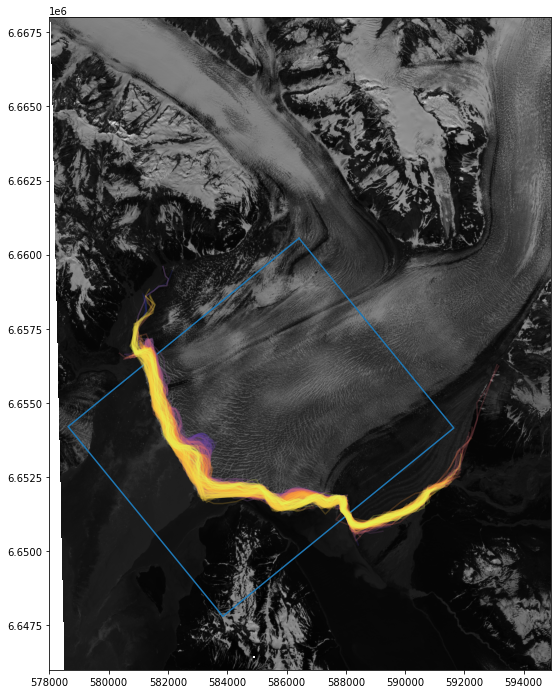

In [169]:
# # read in a nice S2 image over Hubbard and the terminus box
img_path = '/Users/jukesliu/Documents/PhD/Cryohackathon2023/20220704T205029_20220704T205030_T07VEG.TIF'
img_reader = rio.open(img_path); img = img_reader.read(4) # read in image (one band, red)
# window bounds(UTM):
left = 578000
right = 595000
top = 6.668e6
bottom = 6.646e6
window = from_bounds(left, bottom, right, top, img_reader.transform)

# terminus box
box_path = '/Users/jukesliu/Documents/PhD/Cryohackathon2023/BoxHubbard.shp'
box_shp = fiona.open(box_path) # open with fiona
box_coords = box_shp.next()['geometry']['coordinates'][0] # grab coordinates
box_x, box_y = list(zip(*box_coords))

# plot
colors = cmocean.cm.thermal(np.linspace(0,1,len(traces_df)))
plt.figure(figsize=(12,12))
plt.plot(box_x,box_y) # plot box
col_count = 0
for idx, row in traces_df.iterrows():
    trace_x, trace_y = list(zip(*row.coords))
    plt.plot(trace_x,trace_y, color=colors[col_count], alpha=0.2)
    col_count+=1
show(img_reader.read(4,window=window), cmap='gray', transform = transform(window,img_reader.transform))
plt.show()

## 2) Calculate terminus position change along flowlines, using terminus box (UTM projection)

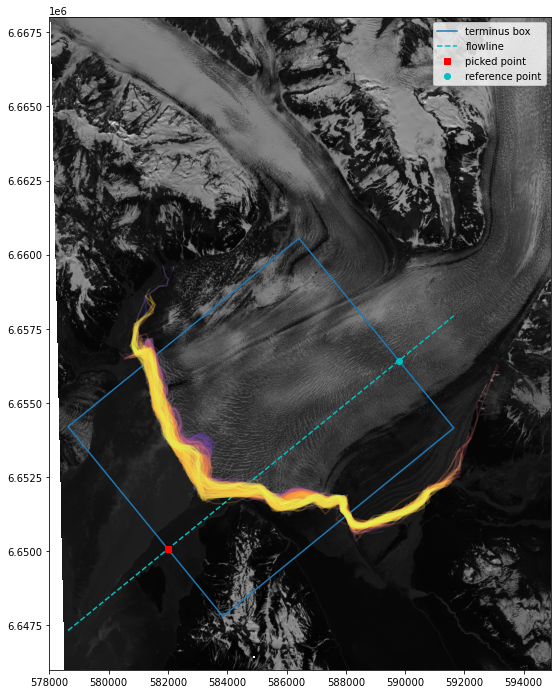

In [265]:
# PICK AN X-COORDINATE ON THE SEAWARD EDGE OF BOX
starting_x = 582000
wslope = (box_y[1] - box_y[0])/(box_x[1] - box_x[0]) # slope along box width
starting_y = box_y[2]-(box_x[2]-starting_x)*wslope # automatically grab the y-coordinate
# grab coordinate on opposite site
opposite_x = (box_x[0]-box_x[3])+starting_x
opposite_y = (box_y[0]-box_y[3])+starting_y
# generate flowline
lslope = (box_y[2] - box_y[1])/(box_x[2] - box_x[1]) # slope on long side of box
xs = np.arange(np.min(box_x), np.max(box_x))
ys = (xs-starting_x)*lslope + starting_y

# plot
plt.figure(figsize=(12,12))
colors = cmocean.cm.thermal(np.linspace(0,1,len(traces_df)))
col_count = 0
plt.plot(box_x, box_y) # original box
plt.plot(xs, ys, 'c--') # flowline
plt.plot(starting_x, starting_y, 'rs') # plot starting point picked
plt.plot(opposite_x, opposite_y, 'co') # plot opposite point on inner side (reference point for relative position)
plt.legend(['terminus box', 'flowline', 'picked point', 'reference point'], loc='upper right')
for idx, row in traces_df.iterrows():
    trace_x, trace_y = list(zip(*row.coords))
    plt.plot(trace_x,trace_y, color=colors[col_count], alpha=0.2)
    col_count+=1

show(img_reader.read(4,window=window), cmap='gray', transform = transform(window,img_reader.transform))
plt.show()

In [266]:
# Calculate relative terminus position
datetimes = []; relative_pos = []
for idx, row in traces_df.iterrows():
    datetime = pd.to_datetime(row.date)
    trace_x, trace_y = list(zip(*row.coords))
    
    # sample terminus trace every meter along the box
    t = np.linspace(0,1,len(trace_x))
    t2 = np.linspace(0,1,len(xs))
    x2 = np.interp(t2, t, trace_x)
    y2 = np.interp(t2, t, trace_y)
    
    # find where traces intersect with the flowline (closest point on trace to point on flowline)
    trace_line = LineString(list(zip(x2, y2)))
    flowline = LineString(list(zip(xs, ys)))
    intersect_pt = trace_line.intersection(flowline)
    if type(intersect_pt) == MultiPoint: # if multiple intersections found
        intersect_pt = intersect_pt.geoms[-1] # grab the first one
    elif type(intersect_pt) == LineString:
        continue # skip the empty linestrings

#     # visualize if desired:
#     plt.plot(x2,y2, '.')
#     plt.plot(trace_x, trace_y, 'rx')
#     plt.plot(xs, ys, 'k--')
#     plt.plot(intersect_pt.x, intersect_pt.y, 'ks')
#     plt.show()
    
    # then calculate that euclidian distance to the reference point (relative terminus position)
    relative_pos.append(dist(intersect_pt.x, intersect_pt.y, opposite_x, opposite_y))
    datetimes.append(datetime)

tpos_df = pd.DataFrame(list(zip(datetimes, relative_pos)), columns=['datetime', 'relative_terminus_position_m'])
tpos_df

,datetime,relative_terminus_position_m
0,2017-01-13,6678.163217
1,2017-01-13,6678.163217
2,2017-01-24,6695.620995
3,2017-02-06,6665.172097
4,2017-02-13,6765.192608
...,...,...
475,2021-12-07,6715.679074
476,2021-12-11,6709.146928
477,2021-12-18,6647.964009
478,2021-12-19,6770.796902


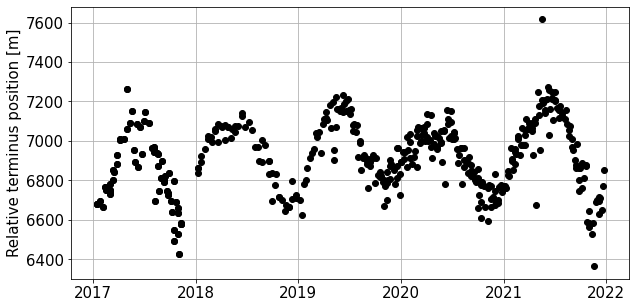

In [272]:
# Plot terminus position time series
fs=15
plt.figure(figsize=(10,5))
plt.plot(tpos_df.datetime, tpos_df.relative_terminus_position_m, 'ko')
plt.tick_params(labelsize=fs)
plt.ylabel('Relative terminus position [m]', fontsize=fs)
plt.grid()
plt.show()